In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

zcross = lambda A: d3.MulCosine(d3.skew(A))
from mydedalustools import *

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [2]:
# Simulation units
meter = 1 / 6.4e6
hour = 1
second = hour / 3600
day = hour*24
taurad=1*day

# Parameters
Nphi = 128
Ntheta = 64
dealias = (3/2, 3/2)
R = 6.4e6 * meter
Omega = 2*np.pi/86400 / second
g = 10 * meter / second**2
deltarho_ov_rho1 = 0.1
gprime = g * deltarho_ov_rho1
#rho1_ov_rho2 = 1/(1+deltarho_ov_rho1)
H = 1e4 * meter
dtype = np.float64

Now let's build two bases for the sphere. First, one to just represent zonally constant fields, and second, one to represent full 2D fields on the sphere:

In [3]:
# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

In [4]:
%time sol_2l_HS_10day_ext  = open_h5('snapshots_2l_HeldSuarez_10days','s2')

CPU times: user 328 ms, sys: 522 ms, total: 850 ms
Wall time: 896 ms


# Balanced height field and unstable eigenmodes in a 2-layer model

## 1. Height field from imposed zonal jet (LBVP)

We start with prescribing a mid-latitude zonal jet, and solving a zonally-symmetric LBVP to find the height field that balances this jet profile.
This will be the background state of our eigenvalue problem.

First we build the background fields using the zonally symmetric basis:

In [5]:
u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
h10 = dist.Field(name='h10', bases=zonal_basis)
u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
h20 = dist.Field(name='h20', bases=zonal_basis)

Next let's setup the zonal jet (the details here are from the reference above):

In [6]:
# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
umax = 30 * meter / second
lat0 = np.pi/4
deltalat=5*np.pi/180
umax = 30 * meter / second
u10['g'] = umax*(np.exp(-(lat-lat0)**2/(2*deltalat**2))+np.exp(-(lat+lat0)**2/(2*deltalat**2)))
u20['g'] = umax*(-np.exp(-(lat-lat0)**2/(2*deltalat**2))-np.exp(-(lat+lat0)**2/(2*deltalat**2)))

We can now solve for the balancing height field (ignoring hyperdiffusivity).
This comes from taking the divergence of the momentum equation, and using a gauge freedom to fix the mean of $h$ to be 0:

In [7]:
# Find balanced height field
c1 = dist.Field(name='c1')
c2 = dist.Field(name='c2')
problem = d3.LBVP([h10,h20, c1,c2], namespace=locals())
problem.add_equation("g*lap(h10+h20) + c1 = - div(u10@grad(u10) + 2*Omega*zcross(u10))")
problem.add_equation("g*lap(h10+h20) + gprime*lap(h20) + c2 = - div(u20@grad(u20) + 2*Omega*zcross(u20))")
problem.add_equation("ave(h10) = H")
problem.add_equation("ave(h20) = H")
solver = problem.build_solver()
solver.solve()

2023-07-17 13:28:04,728 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


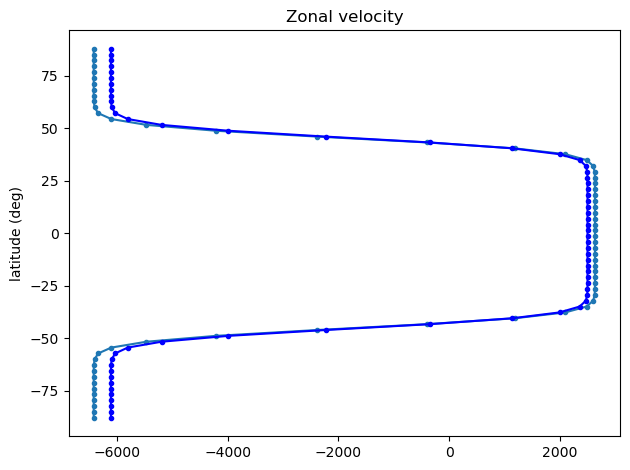

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot((h10['g'][0]-H)/meter, lat[0]*180/np.pi, '.-', color='C0')
ax.plot(-(h20['g'][0]-H)/meter, lat[0]*180/np.pi, '.-', color='b')
ax.set_title('Zonal velocity')
ax.set_ylabel('latitude (deg)')
plt.tight_layout()

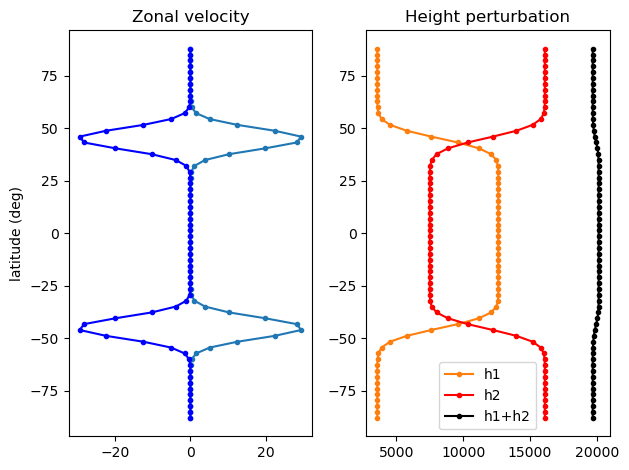

In [9]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '.-', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '.-', color='b')
axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot(h10['g'][0]/meter, lat[0]*180/np.pi, '.-', color='C1', label='h1')
axs[1].plot(h20['g'][0]/meter, lat[0]*180/np.pi, '.-', color='r', label='h2')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '.-', color='k', label='h1+h2')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()

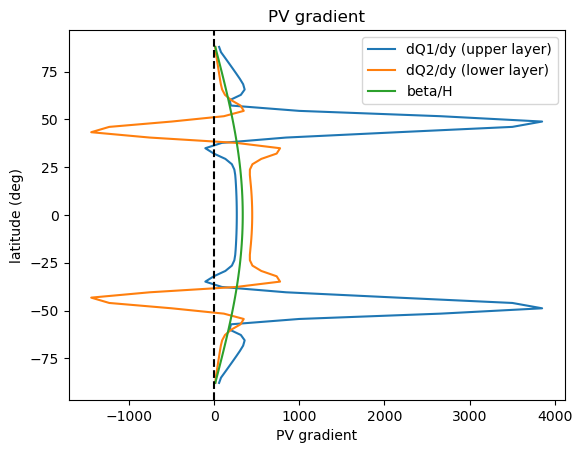

In [10]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

temp = sol_2l_HS_10day_ext.h1[0,0]**0
temp=temp.assign_coords({'theta':temp.latitude*np.pi/180})
theta = temp.theta
u1_ = u10['g'][0][0]*temp
h1_ = h10['g'][0]*temp
u2_ = u20['g'][0][0]*temp
h2_ = h20['g'][0]*temp
f = 2*Omega*np.sin(theta)
beta = 2*Omega*np.cos(theta)/R
Q1 = (f-u1_.differentiate('theta')/R )/h1_
Q2 = (f-u2_.differentiate('theta')/R )/h2_


(Q1.differentiate('theta')/R).plot(y='latitude',label='dQ1/dy (upper layer)')
(Q2.differentiate('theta')/R).plot(y='latitude',label='dQ2/dy (lower layer)')
(beta/H).plot(y='latitude',label='beta/H')
plt.axvline(0.,color='k',linestyle='--')
plt.xlabel('PV gradient')
plt.ylabel('latitude (deg)')
plt.title('PV gradient')
plt.legend()

## 2. Equilibrium height field and jets from imposed relaxation profile

In [28]:
u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
h10 = dist.Field(name='h10', bases=zonal_basis)
u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
h20 = dist.Field(name='h20', bases=zonal_basis)

# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
umax = 30 * meter / second
lat0 = np.pi/4
deltalat=5*np.pi/180
umax = 30 * meter / second
u10['g'] = umax*(np.exp(-(lat-lat0)**2/(2*deltalat**2))+np.exp(-(lat+lat0)**2/(2*deltalat**2)))
u20['g'] = umax*(-np.exp(-(lat-lat0)**2/(2*deltalat**2))-np.exp(-(lat+lat0)**2/(2*deltalat**2)))

# Find balanced height field
c1 = dist.Field(name='c1')
c2 = dist.Field(name='c2')
problem = d3.LBVP([h10,h20, c1,c2], namespace=locals())
problem.add_equation("g*lap(h10+h20) + c1 = - div(u10@grad(u10) + 2*Omega*zcross(u10))")
problem.add_equation("g*lap(h10+h20) + gprime*lap(h20) + c2 = - div(u20@grad(u20) + 2*Omega*zcross(u20))")
problem.add_equation("ave(h10) = H")
problem.add_equation("ave(h20) = H")
solver = problem.build_solver()
solver.solve()

2023-07-17 13:31:11,888 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s


In [29]:
#u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
#h10 = dist.Field(name='h10', bases=zonal_basis)
#u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
#h20 = dist.Field(name='h20', bases=zonal_basis)
hb = dist.Field(name='hb', bases=zonal_basis)
h10_ref = dist.Field(name='h10_ref', bases=zonal_basis)
h20_ref = dist.Field(name='h20_ref', bases=zonal_basis)


#phi, theta = dist.local_grids(zonal_basis)
#lat = np.pi / 2 - theta + 0*phi
#hvar = 1.4*H*0.25*(1-3*np.sin(lat)**2)
h10_ref['g'] = h10['g']# hvar+H
h20_ref['g'] = h20['g']#-hvar+H

h10['g'] = h10_ref['g']
h20['g'] = h20_ref['g']
#hb['g'] = -1.*H*np.sin(lat)**2

#phi, theta = dist.local_grids(zonal_basis)
#lat = np.pi / 2 - theta
#u10 = d3.skew(g*d3.grad(h10+h20)).evaluate()
#u10.change_scales(1)
#u10['g']/=(2*Omega*np.sin(lat))
#u20 = d3.skew(g*d3.grad(h10+h20)+gprime*d3.grad(h20)).evaluate()
#u20.change_scales(1)
#u20['g']/=(2*Omega*np.sin(lat))

# Find balanced height field
taurad=10*day
taudrag=10*day;upperlayer_drag=0
nu = 50*1e5 * meter**2 / second / 32**2
problem_HS = d3.NLBVP([h10,h20,u10,u20], namespace=locals())
problem_HS.add_equation("nu*lap(lap(u10)) + 2*Omega*zcross(u10) + u10/taudrag*upperlayer_drag = -g*grad(h10+h20+hb)")
problem_HS.add_equation("nu*lap(lap(u20)) + 2*Omega*zcross(u20) + u20/taudrag = -g*grad(h10+h20+hb) - gprime*grad(h20+hb)")
problem_HS.add_equation("nu*lap(lap(h10)) + div(u10*h10) = (h10_ref-h10)/taurad")
problem_HS.add_equation("nu*lap(lap(h20)) + div(u20*h20) = (h20_ref-h20)/taurad")

ncc_cutoff = 1e-7
tolerance = 6e-3
u10.change_scales(dealias)
h10.change_scales(dealias)
u20.change_scales(dealias)
h20.change_scales(dealias)
h10_ref.change_scales(dealias)
h20_ref.change_scales(dealias)
solver_HS = problem_HS.build_solver(ncc_cutoff=ncc_cutoff),
pert_norm = np.inf

while pert_norm > tolerance:
    print(len(solver_HS))
    solver_HS[0].newton_iteration(damping=1)
    #solver_HS[1].newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[0].perturbations)
    #pert_norm1 = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[1].perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
    #logger.info(f'Perturbation norm1: {pert_norm1:.3e}')



1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-17 13:31:12,600 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2023-07-17 13:31:12,624 __main__ 0/1 INFO :: Perturbation norm: 1.427e-01
1
2023-07-17 13:31:13,278 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2023-07-17 13:31:13,297 __main__ 0/1 INFO :: Perturbation norm: 1.433e-01
1
2023-07-17 13:31:13,975 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2023-07-17 13:31:13,997 __main__ 0/1 INFO :: Perturbation norm: 5.508e-02
1
2023-07-17 13:31:14,726 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2023-07-17 13:31:14,745 __main__ 0/1 INFO :: Perturbation norm: 1.639e-02
1
2023-07-17 13:31:15,414 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2023-07-17 13:31:15,432 __main__ 0/1

In [30]:
#problem_HS_lin = d3.LBVP([u10,u20], namespace=locals())
#problem_HS_lin.add_equation("2*Omega*zcross(u10) + u10/taudrag = -g*grad(h10+h20)")
#problem_HS_lin.add_equation("2*Omega*zcross(u20) + u20/taudrag = -g*grad(h10+h20) - gprime*grad(h20)")
#solver_HS_lin = problem_HS_lin.build_solver()
#solver_HS_lin.solve()

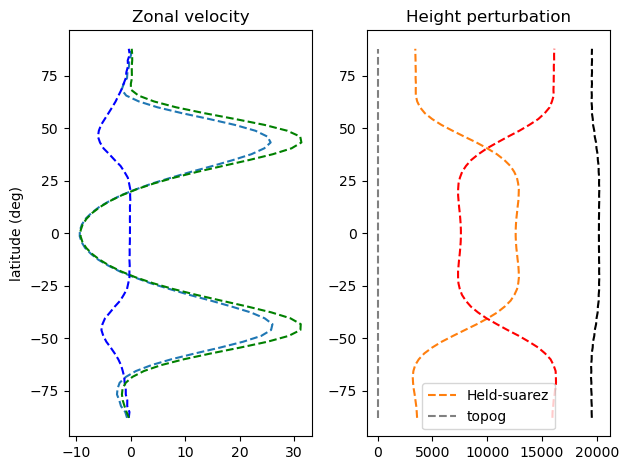

In [31]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='C0')
#axs[0].plot(sol_2l_HS_10day_ext.u1[-1,0].mean('longitude')/(meter/second), lat[0]*180/np.pi, '.-', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='b')
#axs[0].plot(sol_2l_HS_10day_ext.u2[-1,0].mean('longitude')/(meter/second), lat[0]*180/np.pi, '.-', color='b')
axs[0].plot((u10['g'][0][0]-u20['g'][0][0])/(meter/second), lat[0]*180/np.pi, '--', color='g')

axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot(h10['g'][0]/meter, lat[0]*180/np.pi, '--', color='C1', label='Held-suarez')
#axs[1].plot(sol_2l_HS_10day_ext.h1[-1].mean('longitude')/(meter), lat[0]*180/np.pi, '.-', color='C1')
axs[1].plot(h20['g'][0]/meter, lat[0]*180/np.pi, '--', color='r')
#axs[1].plot(sol_2l_HS_10day_ext.h2[-1].mean('longitude')/(meter), lat[0]*180/np.pi, '.-', color='r')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '--', color='k')
hb.change_scales(1);axs[1].plot(hb['g'][0]/meter, lat[0]*180/np.pi, '--', color='gray', label='topog')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()

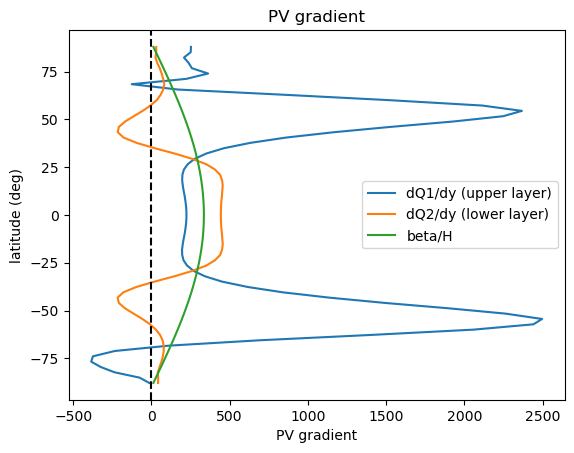

In [32]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

sol_2l_HS_10day_ext = sol_2l_HS_10day_ext.assign_coords({'theta':sol_2l_HS_10day_ext.latitude*np.pi/180})
temp = sol_2l_HS_10day_ext.h1[0,0]**0
theta = temp.theta
u1_ = u10['g'][0][0]*temp
h1_ = h10['g'][0]*temp
u2_ = u20['g'][0][0]*temp
h2_ = h20['g'][0]*temp
f = 2*Omega*np.sin(theta)
beta = 2*Omega*np.cos(theta)/R
Q1 = (f-u1_.differentiate('theta')/R )/h1_
Q2 = (f-u2_.differentiate('theta')/R )/h2_

(Q1.differentiate('theta')/R).plot(y='latitude',label='dQ1/dy (upper layer)')
(Q2.differentiate('theta')/R).plot(y='latitude',label='dQ2/dy (lower layer)')
(beta/H).plot(y='latitude',label='beta/H')
plt.axvline(0.,color='k',linestyle='--')
plt.xlabel('PV gradient')
plt.ylabel('latitude (deg)')
plt.title('PV gradient')
plt.legend()

## Eigenmodes, earth-like circulation

In [29]:
taurad = 1*day

In [30]:
# Perturbation fields
u11 = dist.VectorField(coords, name='u11', bases=full_basis)
h11 = dist.Field(name='h11', bases=full_basis)
u21 = dist.VectorField(coords, name='u21', bases=full_basis)
h21 = dist.Field(name='h21', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u11,u21, h11,h21], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u11 + u11@grad(u10) + u10@grad(u11) + nu*lap(lap(u11)) + g*grad(h11+h21) + 2*Omega*zcross(u11) = 0")
problem.add_equation("sigma*u21 + u21@grad(u20) + u20@grad(u21) + nu*lap(lap(u21)) + g*grad(h11+h21) + gprime*grad(h21) + 2*Omega*zcross(u21) = 0")
problem.add_equation("sigma*h11 + div(h10*u11) + div(h11*u10) + nu*lap(lap(h11)) + h11/taurad = 0");
problem.add_equation("sigma*h21 + div(h20*u21) + div(h21*u20) + nu*lap(lap(h21)) + h21/taurad = 0");




The eigenvalue solver (like all solvers in Dedalus) splits up the problem into its *linearly separable subproblems*.
Each of these *subproblems* is represented by a separate matrix -- these are the things constructed when you build a solver object, and together these form the diagonal blocks of the total linear system.
Here we have NCCs (the background flow) that depend on the latitude, meaning the system is linearly coupled over all $\ell$ for each $m$.

In any event, the eigenvalue solver allows you to find the eigenvalues for each subproblem independently.
The subproblems are objects in the `solver.subproblems` list.
Each has a `.group` attribute that describes the corresponding mode (wavenumber or spherical harmonic order/degree).
You can use the `solver.subproblems_by_group` dictionary to find the object associated with a given horizontal mode, here in the form `(m, None)` to indicate the matrices that couple all $\ell$ for a given $m$.

Here lets loop over the subproblems and compute the fastest growing mode for the first 15 spherical harmonic orders.

In [31]:
%%time
# Eigenvalue solver
m_max = 7
growth_rate = np.zeros(m_max + 1)
solver = problem.build_solver()
for m in range(m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-11 13:23:07,261 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.6e-01/s
2023-07-11 13:23:10,495 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.1e-01/s
2023-07-11 13:23:13,913 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:17,549 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.8e-01/s
2023-07-11 13:23:21,016 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:24,477 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:27,866 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:31,170 subsystems 0/1 INFO :: Building subproblem matrices 

Now let's plot the growth rates:

Text(0, 0.5, 'growth rate')

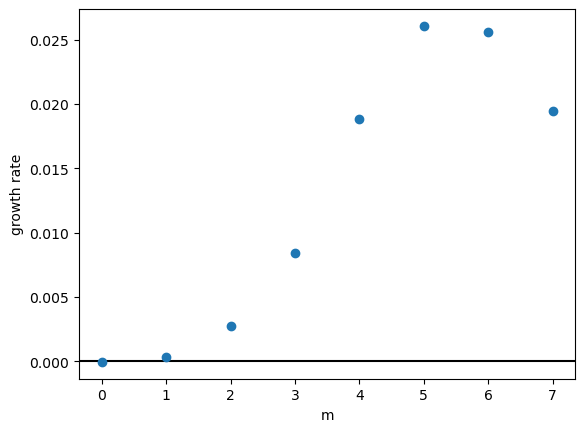

In [32]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')

In [39]:
sp = solver.subproblems_by_group[(6, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

Now we can plot e.g. the height perturbation in the eigenmode:

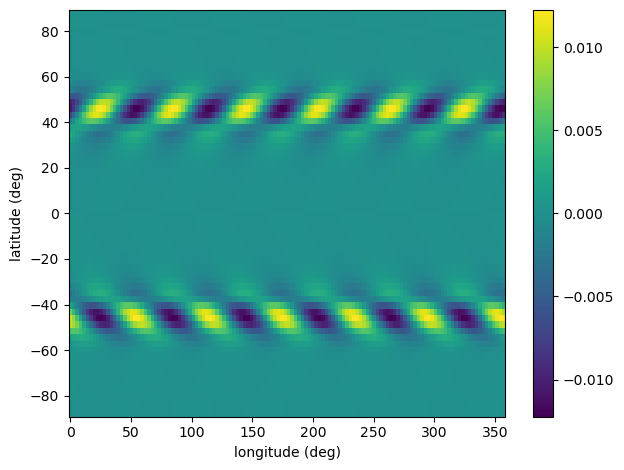

In [40]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

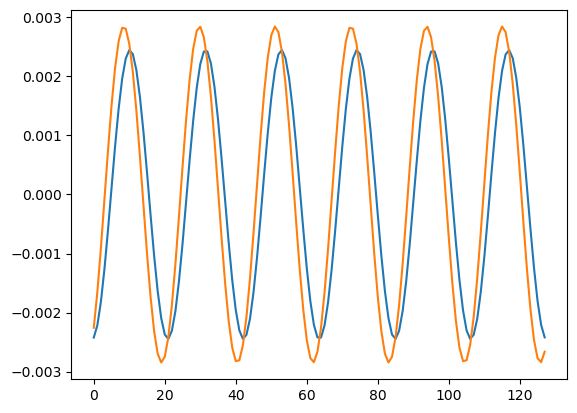

In [41]:
plt.plot(10*(h11['g'][:,-12]+h21['g'][:,-12]))
plt.plot(10*(h11['g'][:,-12]+h21['g'][:,-12])+h21['g'][:,-12])

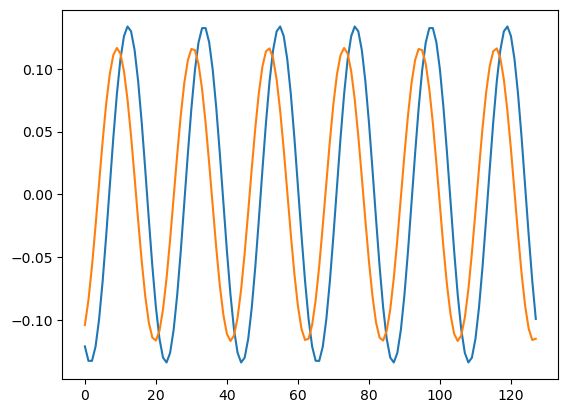

In [42]:
plt.plot(u11['g'][0,:,-12])
plt.plot(u21['g'][0,:,-12])

## Eigenmodes, Held-Suarez forcing circulation

In [86]:
u10.change_scales(1)
u20.change_scales(1)
h10.change_scales(1)
h20.change_scales(1)

In [87]:
u10['g'][:,0,:]=sol_2l_HS_10day_ext.u1[-1].mean('longitude').data
u20['g'][:,0,:]=sol_2l_HS_10day_ext.u2[-1].mean('longitude').data

In [90]:
h10['g'][0]=sol_2l_HS_10day_ext.h1[-1].mean('longitude').data
h20['g'][0]=sol_2l_HS_10day_ext.h2[-1].mean('longitude').data

In [91]:
# Perturbation fields
u11 = dist.VectorField(coords, name='u11', bases=full_basis)
h11 = dist.Field(name='h11', bases=full_basis)
u21 = dist.VectorField(coords, name='u21', bases=full_basis)
h21 = dist.Field(name='h21', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u11,u21, h11,h21], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u11 + u11@grad(u10) + u10@grad(u11) + nu*lap(lap(u11)) + g*grad(h11+h21) + 2*Omega*zcross(u11) + u11/taudrag = 0")
problem.add_equation("sigma*u21 + u21@grad(u20) + u20@grad(u21) + nu*lap(lap(u21)) + g*grad(h11+h21) + gprime*grad(h21) + 2*Omega*zcross(u21) + u21/taudrag  = 0")
problem.add_equation("sigma*h11 + div(h10*u11) + div(h11*u10) + nu*lap(lap(h11)) + h11/taurad = 0");
problem.add_equation("sigma*h21 + div(h20*u21) + div(h21*u20) + nu*lap(lap(h21)) + h21/taurad = 0");




The eigenvalue solver (like all solvers in Dedalus) splits up the problem into its *linearly separable subproblems*.
Each of these *subproblems* is represented by a separate matrix -- these are the things constructed when you build a solver object, and together these form the diagonal blocks of the total linear system.
Here we have NCCs (the background flow) that depend on the latitude, meaning the system is linearly coupled over all $\ell$ for each $m$.

In any event, the eigenvalue solver allows you to find the eigenvalues for each subproblem independently.
The subproblems are objects in the `solver.subproblems` list.
Each has a `.group` attribute that describes the corresponding mode (wavenumber or spherical harmonic order/degree).
You can use the `solver.subproblems_by_group` dictionary to find the object associated with a given horizontal mode, here in the form `(m, None)` to indicate the matrices that couple all $\ell$ for a given $m$.

Here lets loop over the subproblems and compute the fastest growing mode for the first 15 spherical harmonic orders.

In [92]:
%%time
# Eigenvalue solver
m_max = 7
growth_rate = np.zeros(m_max + 1)
solver = problem.build_solver()
for m in range(m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-12 06:58:11,325 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.8e-01/s
2023-07-12 06:58:14,322 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:17,377 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:20,417 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:23,368 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:26,269 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:29,100 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-12 06:58:31,888 subsystems 0/1 INFO :: Building subproblem matrices 

Now let's plot the growth rates:

Text(0.5, 1.0, 'Growth rates, held-suarez equilibrium height fields, $\\tau_{rad} = 1$ day, $\\tau_{drag} = 100$ days')

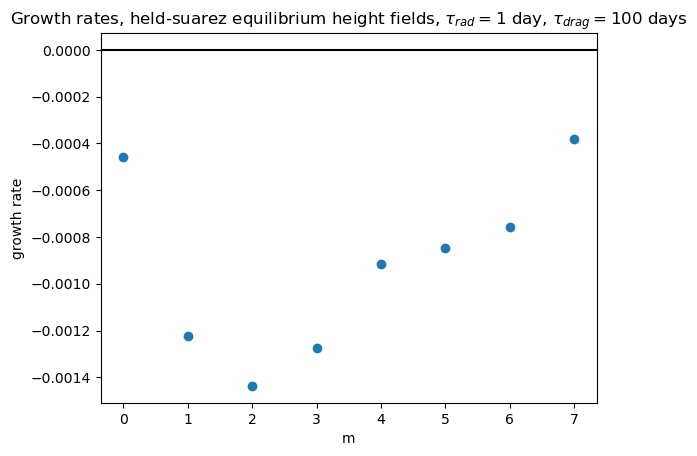

In [50]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, held-suarez equilibrium height fields, $\tau_{rad} = 1$ day, $\tau_{drag} = 100$ days")

Text(0.5, 1.0, 'Growth rates, held-suarez equilibrium height fields, $\\tau_{rad} = 10$ days, $\\tau_{drag} = 100$ days')

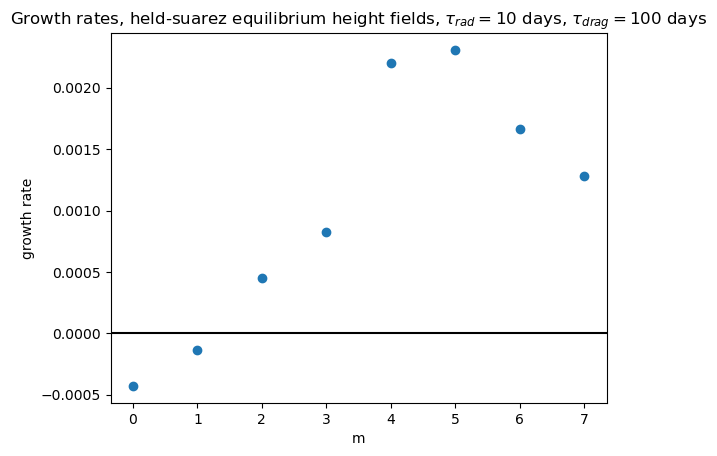

In [55]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, held-suarez equilibrium height fields, $\tau_{rad} = 10$ days, $\tau_{drag} = 100$ days")

Text(0.5, 1.0, 'Growth rates, held-suarez, profiles from simulation, $\\tau_{rad} = 10$ days, $\\tau_{drag} = 100$ days')

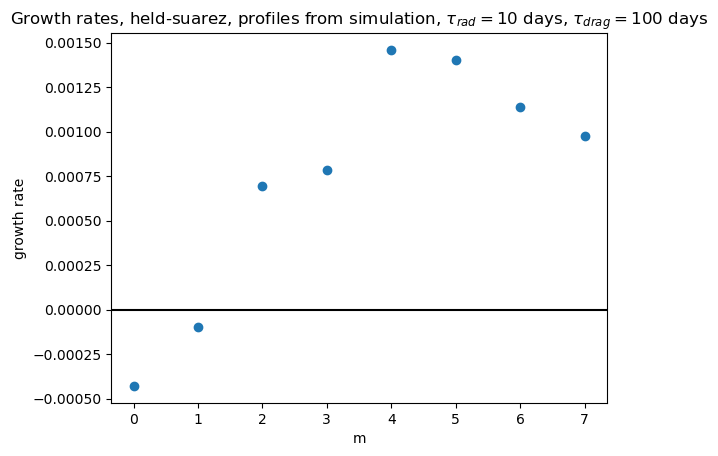

In [93]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, held-suarez, profiles from simulation, $\tau_{rad} = 10$ days, $\tau_{drag} = 100$ days")

Text(0.5, 1.0, 'Growth rates, held-suarez equilibrium height fields, $\\tau_{rad} = 10$ days, $\\tau_{drag} = 10$ days')

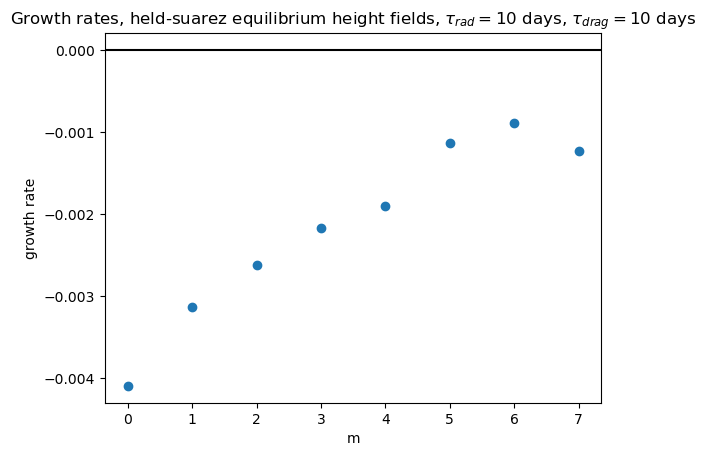

In [63]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, held-suarez equilibrium height fields, $\tau_{rad} = 10$ days, $\tau_{drag} = 10$ days")

In [94]:
sp = solver.subproblems_by_group[(5, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/dedalus/tools/array.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  dest[:] = src


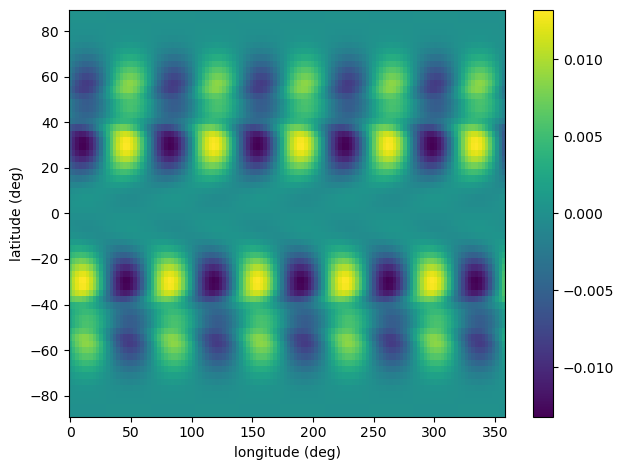

In [71]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

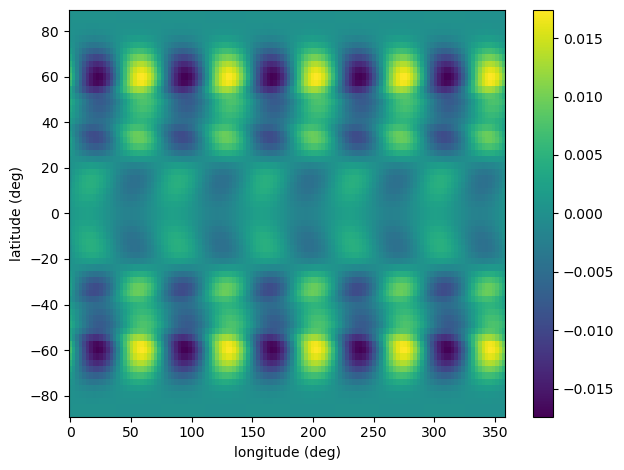

In [95]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

# New forcing profile - cos^4

## Equilibrium height and wind fields

In [38]:
u10 = dist.VectorField(coords, name='u10', bases=zonal_basis)
h10 = dist.Field(name='h10', bases=zonal_basis)
u20 = dist.VectorField(coords, name='u20', bases=zonal_basis)
h20 = dist.Field(name='h20', bases=zonal_basis)
h10_ref = dist.Field(name='h10_ref', bases=zonal_basis)
h20_ref = dist.Field(name='h10_ref', bases=zonal_basis)


phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
hvar = -1.5*H*(8/15-np.cos(lat)**4)#H*np.exp(-(lat)**2/(2*(20*np.pi/180)**2))#
hvar=hvar-np.mean(hvar)
h10_ref['g'] =  hvar+H
h20_ref['g'] = -hvar+H
h10['g'] = h10_ref['g']
h20['g'] = h20_ref['g']


phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta
u10 = d3.skew(g*d3.grad(h10+h20)).evaluate()
u10.change_scales(1)
u10['g']/=(2*Omega*np.sin(lat))
u20 = d3.skew(g*d3.grad(h10+h20)+gprime*d3.grad(h20)).evaluate()
u20.change_scales(1)
u20['g']/=(2*Omega*np.sin(lat))

# Find balanced height field
taurad=10*day
taudrag=100*day
nu = 1e5 * meter**2 / second / 32**2*30
problem_HS = d3.NLBVP([h10,h20,u10,u20], namespace=locals())
problem_HS.add_equation("nu*lap(lap(u10)) + 2*Omega*zcross(u10) + u10/taudrag = -g*grad(h10+h20)")
problem_HS.add_equation("nu*lap(lap(u20)) + 2*Omega*zcross(u20) + u20/taudrag = -g*grad(h10+h20) - gprime*grad(h20)")
problem_HS.add_equation("nu*lap(lap(h10)) + div(u10*h10) = (h10_ref-h10)/taurad")
problem_HS.add_equation("nu*lap(lap(h20)) + div(u20*h20) = (h20_ref-h20)/taurad")

ncc_cutoff = 1e-5
tolerance = 5e-5
u10.change_scales(dealias)
h10.change_scales(dealias)
u20.change_scales(dealias)
h20.change_scales(dealias)
h10_ref.change_scales(dealias)
h20_ref.change_scales(dealias)
solver_HS = problem_HS.build_solver(ncc_cutoff=ncc_cutoff),
pert_norm = np.inf

while pert_norm > tolerance:
    print(len(solver_HS))
    solver_HS[0].newton_iteration(damping=1)
    #solver_HS[1].newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[0].perturbations)
    #pert_norm1 = sum(pert.allreduce_data_norm('c', 2) for pert in solver_HS[1].perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
    #logger.info(f'Perturbation norm1: {pert_norm1:.3e}')



1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-13 06:35:48,992 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2023-07-13 06:35:48,998 __main__ 0/1 INFO :: Perturbation norm: 1.209e-02
1
2023-07-13 06:35:49,544 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2023-07-13 06:35:49,550 __main__ 0/1 INFO :: Perturbation norm: 1.091e-03
1
2023-07-13 06:35:50,055 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2023-07-13 06:35:50,061 __main__ 0/1 INFO :: Perturbation norm: 6.251e-05
1
2023-07-13 06:35:50,589 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2023-07-13 06:35:50,595 __main__ 0/1 INFO :: Perturbation norm: 8.769e-06


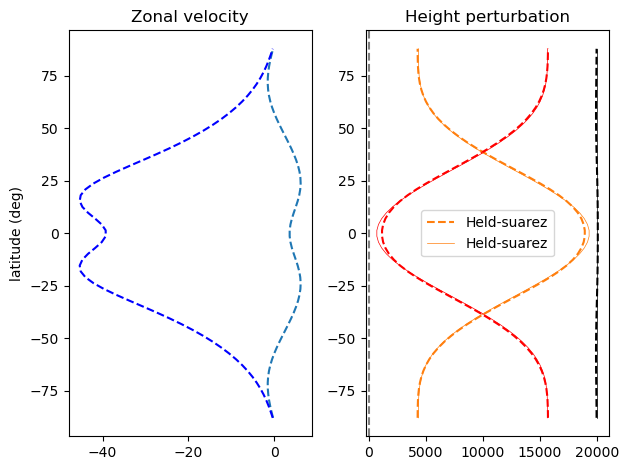

In [39]:
u10.change_scales(1)
h10.change_scales(1)
h10_ref.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)
h20_ref.change_scales(1)

fig, axs = plt.subplots(1,2)
axs[0].plot(u10['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='C0')
axs[0].plot(u20['g'][0][0]/(meter/second), lat[0]*180/np.pi, '--', color='b')
axs[0].set_title('Zonal velocity')
axs[0].set_ylabel('latitude (deg)')
axs[1].plot(h10['g'][0]/meter, lat[0]*180/np.pi, '--', color='C1', label='Held-suarez')
axs[1].plot(h20['g'][0]/meter, lat[0]*180/np.pi, '--', color='r')
axs[1].plot((h10['g'][0]+h20['g'][0])/meter, lat[0]*180/np.pi, '--', color='k')
axs[1].plot(h10_ref['g'][0]/meter, lat[0]*180/np.pi, '-',linewidth=0.5, color='C1', label='Held-suarez')
axs[1].plot(h20_ref['g'][0]/meter, lat[0]*180/np.pi, '-',linewidth=0.5, color='r')
axs[1].plot((h10_ref['g'][0]+h20_ref['g'][0])/meter, lat[0]*180/np.pi, '-',linewidth=0.5, color='k')
axs[1].axvline(0.,color='gray',linestyle='--')
axs[1].set_title('Height perturbation')
axs[1].legend()
plt.tight_layout()

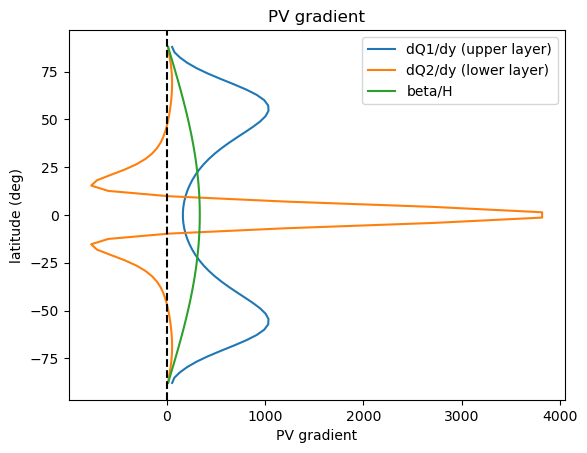

In [40]:
u10.change_scales(1)
h10.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)

temp = sol_2l_HS_10day_ext.h1[0,0]**0
temp=temp.assign_coords({'theta':temp.latitude*np.pi/180})
theta = temp.theta
u1_ = u10['g'][0][0]*temp
h1_ = h10['g'][0]*temp
u2_ = u20['g'][0][0]*temp
h2_ = h20['g'][0]*temp
f = 2*Omega*np.sin(theta)
beta = 2*Omega*np.cos(theta)/R
Q1 = (f-u1_.differentiate('theta')/R )/h1_
Q2 = (f-u2_.differentiate('theta')/R )/h2_

Q1_2 = (f-u1_.differentiate('theta')/R )/H
Q2_2 = (f-u2_.differentiate('theta')/R )/H



(Q1.differentiate('theta')/R).plot(y='latitude',label='dQ1/dy (upper layer)')
(Q2.differentiate('theta')/R).plot(y='latitude',label='dQ2/dy (lower layer)')
#Q1_2.differentiate('theta').plot(y='latitude',color='C0',linestyle='--')
#Q2_2.differentiate('theta').plot(y='latitude',color='C1',linestyle='--')
(beta/H).plot(y='latitude',label='beta/H')
plt.axvline(0.,color='k',linestyle='--')
plt.xlabel('PV gradient')
plt.ylabel('latitude (deg)')
plt.title('PV gradient')
plt.legend()

## Eigenmodes

In [41]:
u10.change_scales(1)
h10.change_scales(1)
h10_ref.change_scales(1)
u20.change_scales(1)
h20.change_scales(1)
h20_ref.change_scales(1)

In [42]:
# Perturbation fields
u11 = dist.VectorField(coords, name='u11', bases=full_basis)
h11 = dist.Field(name='h11', bases=full_basis)
u21 = dist.VectorField(coords, name='u21', bases=full_basis)
h21 = dist.Field(name='h21', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u11,u21, h11,h21], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u11 + u11@grad(u10) + u10@grad(u11) + nu*lap(lap(u11)) + g*grad(h11+h21) + 2*Omega*zcross(u11) + u11/taudrag = 0")
problem.add_equation("sigma*u21 + u21@grad(u20) + u20@grad(u21) + nu*lap(lap(u21)) + g*grad(h11+h21) + gprime*grad(h21) + 2*Omega*zcross(u21) + u21/taudrag  = 0")
problem.add_equation("sigma*h11 + div(h10*u11) + div(h11*u10) + nu*lap(lap(h11)) + h11/taurad = 0");
problem.add_equation("sigma*h21 + div(h20*u21) + div(h21*u20) + nu*lap(lap(h21)) + h21/taurad = 0");




The eigenvalue solver (like all solvers in Dedalus) splits up the problem into its *linearly separable subproblems*.
Each of these *subproblems* is represented by a separate matrix -- these are the things constructed when you build a solver object, and together these form the diagonal blocks of the total linear system.
Here we have NCCs (the background flow) that depend on the latitude, meaning the system is linearly coupled over all $\ell$ for each $m$.

In any event, the eigenvalue solver allows you to find the eigenvalues for each subproblem independently.
The subproblems are objects in the `solver.subproblems` list.
Each has a `.group` attribute that describes the corresponding mode (wavenumber or spherical harmonic order/degree).
You can use the `solver.subproblems_by_group` dictionary to find the object associated with a given horizontal mode, here in the form `(m, None)` to indicate the matrices that couple all $\ell$ for a given $m$.

Here lets loop over the subproblems and compute the fastest growing mode for the first 15 spherical harmonic orders.

In [43]:
%%time
# Eigenvalue solver
m_max = 7
growth_rate = np.zeros(m_max + 1)
solver = problem.build_solver()
for m in range(m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-13 06:36:30,542 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-13 06:36:33,238 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s
2023-07-13 06:36:36,189 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.2e-01/s
2023-07-13 06:36:39,131 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.1e-01/s
2023-07-13 06:36:42,038 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-13 06:36:44,900 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2023-07-13 06:36:47,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s
2023-07-13 06:36:50,430 subsystems 0/1 INFO :: Building subproblem matrices 

Text(0.5, 1.0, 'Growth rates, cos^4 equilibrium height field, $\\tau_{rad} = 1$ day, $\\tau_{drag} = 10$ days')

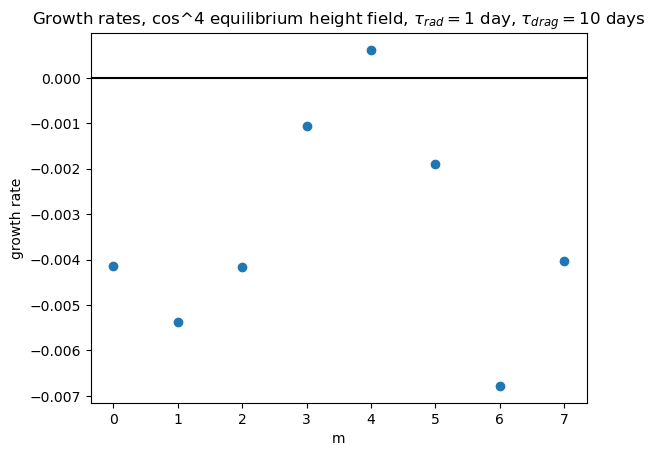

In [151]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, cos^4 equilibrium height field, $\tau_{rad} = 1$ day, $\tau_{drag} = 10$ days")

Text(0.5, 1.0, 'Growth rates, cos^4 equilibrium height field, $\\tau_{rad} = 10$ day, $\\tau_{drag} = 10$ days')

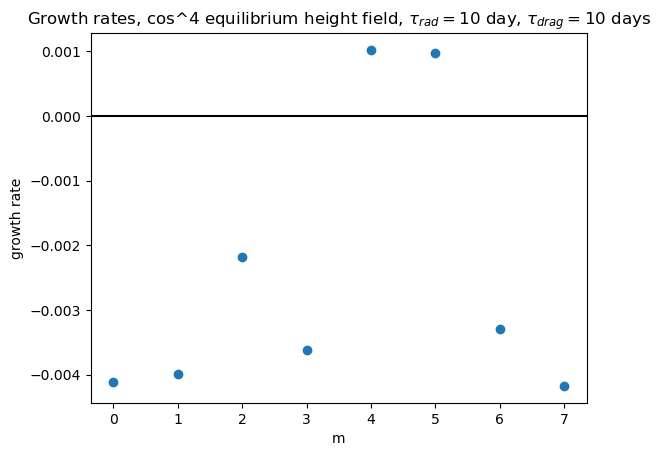

In [122]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, cos^4 equilibrium height field, $\tau_{rad} = 10$ day, $\tau_{drag} = 10$ days")

In [123]:
sp = solver.subproblems_by_group[(4, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/dedalus/tools/array.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  dest[:] = src


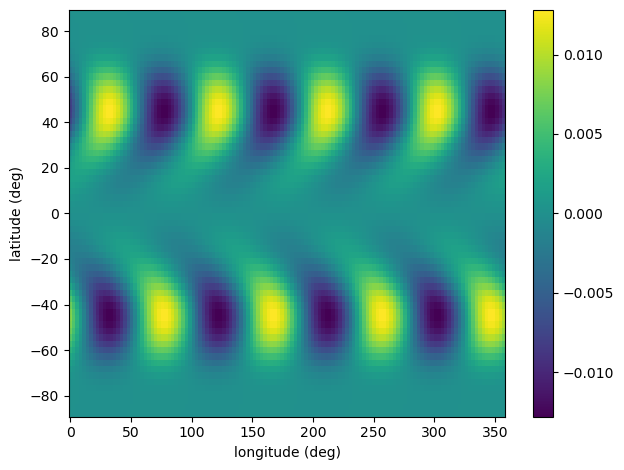

In [124]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

Text(0.5, 1.0, 'Growth rates, cos^4 equilibrium height field, $\\tau_{rad} = 10$ days, $\\tau_{drag} = 100$ days')

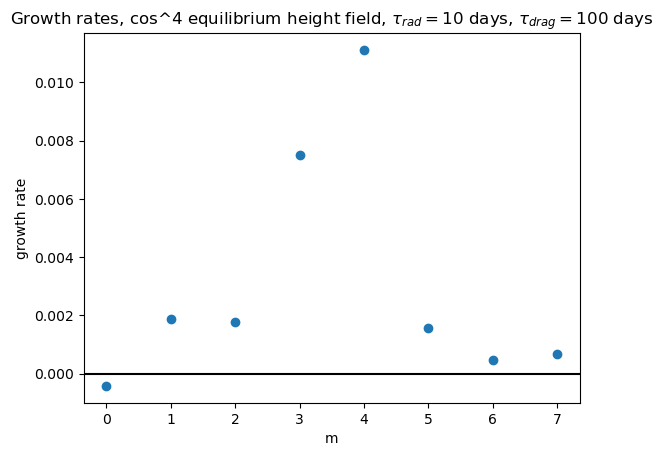

In [44]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')
plt.title(r"Growth rates, cos^4 equilibrium height field, $\tau_{rad} = 10$ days, $\tau_{drag} = 100$ days")

In [45]:
sp = solver.subproblems_by_group[(4, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/dedalus/tools/array.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  dest[:] = src


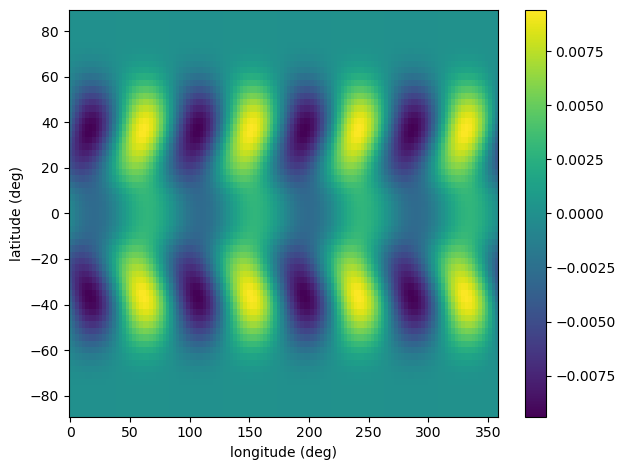

In [46]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

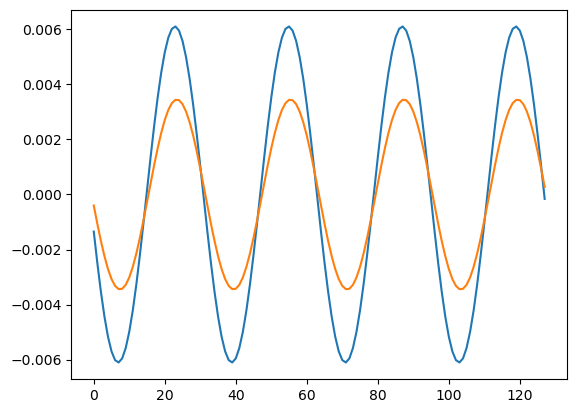

In [47]:
plt.plot(10*(h11['g'][:,-12]+h21['g'][:,-12]))
plt.plot(10*(h11['g'][:,-12]+h21['g'][:,-12])+h21['g'][:,-12])